# LangChain Text to SQL

based on https://python.langchain.com/docs/tutorials/sql_qa/

In [ ]:
from langchain_community.utilities import SQLDatabase

# get chinookdb for example from https://www.sqlitetutorial.net/sqlite-sample-database/
# relative path to chinook.db
path_sqlite_chinook_db =  "../../DATA/EXAMPLEFILES/SQLITE/chinook.db"
db = SQLDatabase.from_uri("sqlite:///" + path_sqlite_chinook_db)
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM ARTISTS LIMIT 10;")

In [ ]:
from typing_extensions import TypedDict

class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [14]:
from langchain.chat_models import init_chat_model
from dotenv import load_dotenv
import os

load_dotenv()

llm = init_chat_model("claude-3-5-haiku-20241022", model_provider="anthropic", api_key=os.getenv("ANTHROPIC_API_KEY"))

llm.invoke(["Hello, how are you?"])


AIMessage(content="I'm doing well, thank you for asking! How are you today? Is there anything I can help you with?", additional_kwargs={}, response_metadata={'id': 'msg_0175wGEhMK3JFeVHXiTQ55kY', 'model': 'claude-3-5-haiku-20241022', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 13, 'output_tokens': 27}, 'model_name': 'claude-3-5-haiku-20241022'}, id='run-6981fdf4-3403-4c3b-ae85-ab5cd0b21d48-0', usage_metadata={'input_tokens': 13, 'output_tokens': 27, 'total_tokens': 40, 'input_token_details': {'cache_read': 0, 'cache_creation': 0}})

In [10]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


In [15]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) AS EmployeeCount FROM employees;'}

In [16]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

execute_query({"query": "SELECT * FROM Employees;"})


{'result': "[(1, 'Adams', 'Andrew', 'General Manager', None, '1962-02-18 00:00:00', '2002-08-14 00:00:00', '11120 Jasper Ave NW', 'Edmonton', 'AB', 'Canada', 'T5K 2N1', '+1 (780) 428-9482', '+1 (780) 428-3457', 'andrew@chinookcorp.com'), (2, 'Edwards', 'Nancy', 'Sales Manager', 1, '1958-12-08 00:00:00', '2002-05-01 00:00:00', '825 8 Ave SW', 'Calgary', 'AB', 'Canada', 'T2P 2T3', '+1 (403) 262-3443', '+1 (403) 262-3322', 'nancy@chinookcorp.com'), (3, 'Peacock', 'Jane', 'Sales Support Agent', 2, '1973-08-29 00:00:00', '2002-04-01 00:00:00', '1111 6 Ave SW', 'Calgary', 'AB', 'Canada', 'T2P 5M5', '+1 (403) 262-3443', '+1 (403) 262-6712', 'jane@chinookcorp.com'), (4, 'Park', 'Margaret', 'Sales Support Agent', 2, '1947-09-19 00:00:00', '2003-05-03 00:00:00', '683 10 Street SW', 'Calgary', 'AB', 'Canada', 'T2P 5G3', '+1 (403) 263-4423', '+1 (403) 263-4289', 'margaret@chinookcorp.com'), (5, 'Johnson', 'Steve', 'Sales Support Agent', 2, '1965-03-03 00:00:00', '2003-10-17 00:00:00', '7727B 41 Av

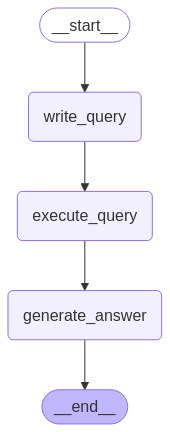

In [18]:
### Generate Answer

def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS EmployeeCount\nFROM employees;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'Based on the SQL query and result, there are 8 employees in the database.'}}
